In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import pyodbc as odbc
from k_means_constrained import KMeansConstrained
import math

# Import Data From SQL
#### Property Data: ModelTestBed..msrportfolio
#### Tech Data: IRSPublish..tv_technicianAddress

In [6]:
Driver_name = 'SQL Server Native Client 11.0'
Server_Name = 'DFILSQL02.insightlabs.amherst.com'
Database_Name = 'IRSPublish'


cnxn = odbc.connect("Driver={SQL Server Native Client 11.0};"
                    "Server=DFILSQL02.insightlabs.amherst.com;"
                    "Trusted_Connection=yes;")

In [7]:
query_lat_long_data = '''
SELECT [PropertyID] as propertyid
      ,[BranchName] as branchname
      ,[State] as state
      ,[CensusTractGeoId]
      ,[latitude] as property_lat
      ,[longitude] as property_long
      ,[SUBDIVISION_NAME] as subdivision_name
  FROM [ModelTestBed].[dbo].[MSRportfolio]
  where [Still Under Mgmt]='Yes'
  and BranchName like '%st louis%'
'''


raw_prop_data = pd.io.sql.read_sql(query_lat_long_data,cnxn)

lat_long_df = raw_prop_data.copy()
lat_long_df = lat_long_df[lat_long_df['state'] == 'MO']
lat_long_df

C:\Users\cpaige\AppData\Local\Temp\ipykernel_4076\4189659364.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  raw_prop_data = pd.io.sql.read_sql(query_lat_long_data,cnxn)


,propertyid,branchname,state,CensusTractGeoId,property_lat,property_long,subdivision_name
0,688715.0,St Louis,MO,29183311124,38.748878,-90.695831,VLG OF PHEA
1,689576.0,St Louis,MO,29189210924,38.825485,-90.324326,BOARDWALK
2,689587.0,St Louis,MO,29189210912,38.820415,-90.283859,RIVER OAK E
3,742920.0,St Louis,MO,29183311322,38.766739,-90.625801,DARDENNE CR
4,746947.0,St Louis,MO,29189210804,38.809879,-90.230721,COUNTRY VIL
...,...,...,...,...,...,...,...
917,9022093.0,St Louis,MO,29183311311,38.786014,-90.615328,
918,9115989.0,St Louis,MO,29099700116,38.405745,-90.406720,
919,9156794.0,St Louis,MO,29189210804,38.796061,-90.253075,
920,9169379.0,St Louis,MO,29071800601,38.446716,-91.021160,


In [8]:
lat_long_df.drop(lat_long_df.loc[lat_long_df['property_long'].isnull()].index, inplace=True)
lat_long_df.drop(lat_long_df.loc[lat_long_df['property_lat'].isnull()].index, inplace=True)

In [9]:
query_techData = """
select distinct ta.branchname, ta.[Primary Home Address - State] as state  ,ta.Worker as tech_name, ta.[Email - Primary Work] as tech_email ,ta.TechZipCode as tech_zip, ZipShp.LAT as tech_lat ,ZipShp.lon as tech_long
from IRSPublish..tv_technicianAddress ta
join thirdpartydata..Shp_ZipCode_dt ZipShp
on ta.TechZipCode=ZipShp.ZipCode
join modeltestbed..msrportfolio msr
on msr.branchname like ta.Branchname+'%'
and [Still Under Mgmt]='Yes'
join thirdpartydata..Shp_Blocks_dt blkShp
on blkShp.fips+blkShp.censusTract+blkshp.BlockGroup=msr.census_block
where ta.branchName = 'St Louis'

"""

raw_tech_data = pd.io.sql.read_sql(query_techData,cnxn)

tech_df = raw_tech_data.copy()
tech_df = tech_df[tech_df['state'] == 'Missouri']
tech_df

C:\Users\cpaige\AppData\Local\Temp\ipykernel_4076\2708271724.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  raw_tech_data = pd.io.sql.read_sql(query_techData,cnxn)


,branchname,state,tech_name,tech_email,tech_zip,tech_lat,tech_long
1,St Louis,Missouri,Donald Sewood,dsewood@msrenewal.com,63033,38.795587,-90.277213
2,St Louis,Missouri,Lewis Jones,lejones@msrenewal.com,63104,38.610854,-90.212699
3,St Louis,Missouri,Richard Carter,ricarter@msrenewal.com,63115,38.677276,-90.239754


# K-Means Clustering Assignments

In [10]:
miniPod_kmeans = KMeansConstrained(n_clusters=len(tech_df), size_min=round(len(lat_long_df) / len(tech_df)) - 3)

lat_long_df['miniPod_id'] = miniPod_kmeans.fit_predict(lat_long_df[['property_lat', 'property_long']])

lat_long_df['miniPod_id'] = lat_long_df['miniPod_id'] + 1

In [11]:
miniPod_centers = miniPod_kmeans.cluster_centers_

In [12]:
miniPod_labels = miniPod_kmeans.predict(lat_long_df[['property_lat', 'property_long']])
miniPod_labels = miniPod_labels + 1

In [13]:
lat_long_df['miniPod_id'].value_counts().sort_index(ascending=True)

1    304
2    314
3    304
Name: miniPod_id, dtype: int64

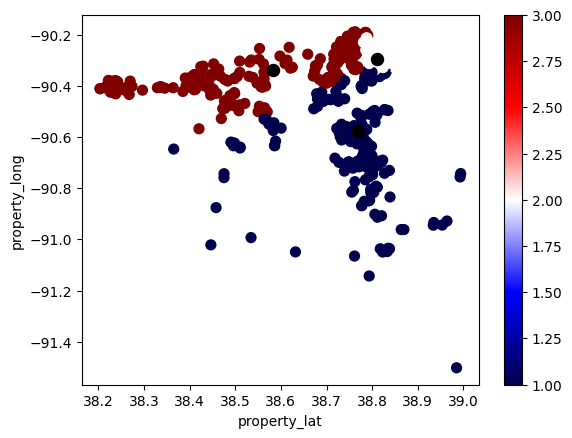

In [14]:
lat_long_df.plot.scatter(x='property_lat', y='property_long', c=miniPod_labels, s=50, cmap= 'seismic')
plt.scatter(miniPod_centers[:, 0], miniPod_centers[:, 1], c='black', s=75, alpha=1)

In [15]:
n_clus = math.ceil(len(lat_long_df)/1500)

In [16]:
bigPod_kmeans = KMeansConstrained(n_clusters=n_clus, size_min=round(len(lat_long_df) / n_clus) - 3)

lat_long_df['bigPod_id'] = bigPod_kmeans.fit_predict(lat_long_df[['property_lat', 'property_long']])

lat_long_df['bigPod_id'] = lat_long_df['bigPod_id'] + 1

In [17]:
bigPod_centers = bigPod_kmeans.cluster_centers_

In [18]:
bigPod_labels = bigPod_kmeans.predict(lat_long_df[['property_lat', 'property_long']])
bigPod_labels = bigPod_labels + 1

In [19]:
lat_long_df['bigPod_id'].value_counts().sort_index(ascending=True)

1    922
Name: bigPod_id, dtype: int64

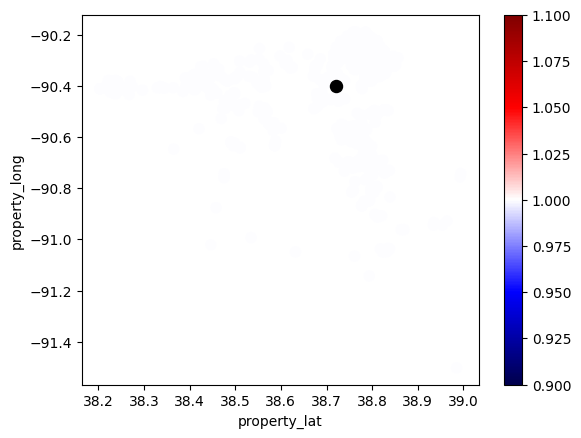

In [20]:
lat_long_df.plot.scatter(x='property_lat', y='property_long', c=bigPod_labels, s=50, cmap= 'seismic')
plt.scatter(bigPod_centers[:, 0], bigPod_centers[:, 1], c='black', s=75, alpha=1)

In [21]:
collected_df = lat_long_df.copy()

In [22]:
def censusTractSplit(collected_df):

    collected_df['fips'] = [x[0:5] for x in collected_df['CensusTractGeoId'].astype(str)]

    df_assign = collected_df.groupby(['fips','subdivision_name'])['miniPod_id'].nunique().to_frame().reset_index()

    df_assign = df_assign[df_assign['miniPod_id']>1]
    df_assign = df_assign.rename(columns={'miniPod_id':'nMiniPods'})

    N_prop = collected_df.groupby(['fips','subdivision_name','miniPod_id'])['propertyid'].count().to_frame().reset_index()
    N_prop = N_prop.rename(columns = {'propertyid':'nProp'})

    to_choose = N_prop.merge(df_assign, left_on=['fips','subdivision_name'], right_on= ['fips','subdivision_name'])

    to_choose['miniPod_rank'] =  to_choose.groupby(['fips','subdivision_name'])['nProp'].rank(method = 'first',ascending=False)

    to_choose = to_choose[to_choose['miniPod_rank']==1][['fips','subdivision_name','miniPod_id']]

    #now we just merge back
    assigned = collected_df.merge(to_choose,how='left', left_on=['fips','subdivision_name'], right_on=['fips','subdivision_name'])
    assigned = assigned.rename(columns={'miniPod_id_x':'prevMiniPodID','miniPod_id_y':'miniPod_id'})

    new_assigned_df = assigned[assigned['miniPod_id'].notnull()].drop('prevMiniPodID', axis=1)

    lst = list(new_assigned_df['propertyid'])

    collected_df.drop(collected_df.loc[collected_df['propertyid'].isin(lst)].index, inplace=True)

    collected_df = pd.concat([collected_df, new_assigned_df])

    collected_df = collected_df.drop('fips', axis=1)

    collected_df['propertyid'] = collected_df['propertyid'].astype(int)
    collected_df['miniPod_id'] = collected_df['miniPod_id'].astype(int)
    collected_df['bigPod_id'] = collected_df['bigPod_id'].astype(int)


    return collected_df


In [23]:
collected_df = censusTractSplit(collected_df)

In [24]:
def same_bigPod(df):

    df_assign = df.groupby(['miniPod_id'])['bigPod_id'].nunique().to_frame().reset_index().rename(columns={'bigPod_id': 'nBigPods'})

    df_assign = df_assign[df_assign['nBigPods']>1]

    n_prop = df.groupby(['miniPod_id', 'bigPod_id'])['propertyid'].count().to_frame().reset_index().rename(columns = {'propertyid':'nProp'})

    to_choose = n_prop.merge(df_assign, left_on='miniPod_id', right_on='miniPod_id')

    to_choose['miniPod_rank'] = to_choose.groupby('miniPod_id')['nProp'].rank(method='first', ascending=False)

    to_choose = to_choose[to_choose['miniPod_rank'] ==1][['miniPod_id', 'bigPod_id']]

    assigned = df.merge(to_choose, how='left', left_on='miniPod_id', right_on='miniPod_id')
    assigned = assigned.rename(columns={'bigPod_id_x':'prevBigPodID','bigPod_id_y':'bigPod_id'})

    new_assigned = assigned[assigned['bigPod_id'].notnull()].drop('prevBigPodID', axis=1)

    lst = list(new_assigned['propertyid'])

    df.drop(df.loc[df['propertyid'].isin(lst)].index, inplace=True)

    new_df = new_assigned[['propertyid', 'branchname', 'CensusTractGeoId', 'property_lat', 'property_long', 'subdivision_name', 'miniPod_id', 'bigPod_id']]

    final_df = pd.concat([df, new_df])

    return final_df

In [25]:
collected_df = same_bigPod(collected_df)

In [26]:
def get_centers():
    centers_df = pd.DataFrame(miniPod_centers)
    centers_df.rename(columns={0:'miniPod_lat', 1:'miniPod_long'}, inplace=True)

    labels_df = pd.DataFrame(set(miniPod_labels))
    labels_df = labels_df.rename(columns={0:'clusterLabel'})

    centers_df['miniPod_id'] = labels_df['clusterLabel']

    centers_df['miniPod_id'] = centers_df['miniPod_id']

    return centers_df

In [27]:
collected_df = collected_df.merge(get_centers(), how='left', on='miniPod_id')

In [28]:
def get_bigPod_center():



    pod_centers = pd.DataFrame(bigPod_centers)
    pod_centers['bigPod_id'] = np.unique(bigPod_labels)
    pod_centers.rename(columns={0:'bigPod_lat', 1:'bigPod_long'}, inplace=True)

    return pod_centers

In [29]:
collected_df = collected_df.merge(get_bigPod_center(), how='left', on='bigPod_id')

In [30]:
import openrouteservice as ors

client = ors.Client(base_url='http://localhost:8080/ors')

def miniPodcenter2prop(row):
    index, value = row
    try:
        coords = ((value["miniPod_long"],value["miniPod_lat"]),(value['property_long'],value['property_lat']))
        routes = client.directions(coords, optimize_waypoints=True ,radiuses=50000)
        result = {
            'propertyid': value['propertyid'],
            'branchname': value['branchname'],
            'CensusTractGeoId' : value['CensusTractGeoId'],
            'subdivision_name': value['subdivision_name'],
            'property_lat': value['property_lat'],
            'property_long': value['property_long'],
            'miniPod_id': value['miniPod_id'],
            'bigPod_id': value['bigPod_id'],
            'miniPod_lat':value['miniPod_lat'],
            'miniPod_long': value['miniPod_long'],
            'bigPod_lat':value['bigPod_lat'],
            'bigPod_long': value['bigPod_long'],
            'miniPodcenter2prop_driving_distance(meters)': routes['routes'][0]['summary']['distance'],
            'miniPodcenter2prop_driving_time(secs)': routes['routes'][0]['summary']['duration']
        }
    except:
        result = {'invalid_row': index}
    return result


from multiprocessing.pool import ThreadPool

pool = ThreadPool(14)
results = pool.map(miniPodcenter2prop, collected_df.iterrows())
pool.close()

C:\Users\cpaige\AppData\Roaming\JetBrains\DataSpell2022.1\projects\workspace\venv\lib\site-packages\openrouteservice\directions.py:202: UserWarning: Less than 4 coordinates, nothing to optimize!
  warnings.warn("Less than 4 coordinates, nothing to optimize!", UserWarning)


In [31]:
collected_df = pd.DataFrame([x_ for x_ in results if not x_.get('invalid_row')])

In [32]:
def bigPododcenter2prop(row):
    index, value = row
    try:
        coords = ((value["bigPod_long"],value["bigPod_lat"]),(value['property_long'],value['property_lat']))
        routes = client.directions(coords, optimize_waypoints=True ,radiuses=50000)
        result = {
            'propertyid': value['propertyid'],
            'branchname': value['branchname'],
            'CensusTractGeoId' : value['CensusTractGeoId'],
            'subdivision_name': value['subdivision_name'],
            'property_lat': value['property_lat'],
            'property_long': value['property_long'],
            'miniPod_id': value['miniPod_id'],
            'bigPod_id': value['bigPod_id'],
            'miniPod_lat':value['miniPod_lat'],
            'miniPod_long': value['miniPod_long'],
            'bigPod_lat': value['bigPod_lat'],
            'bigPod_long': value['bigPod_long'],
            'miniPodcenter2prop_driving_distance(meters)': value['miniPodcenter2prop_driving_distance(meters)'],
            'miniPodcenter2prop_driving_time(secs)': value['miniPodcenter2prop_driving_time(secs)'],
            'bigPodcenter2prop_driving_distance(meters)': routes['routes'][0]['summary']['distance'],
            'bigPodcenter2prop_driving_time(secs)': routes['routes'][0]['summary']['duration']
        }
    except:
        result = {'invalid_row': index}
    return result


from multiprocessing.pool import ThreadPool

pool = ThreadPool(14)
results = pool.map(bigPododcenter2prop, collected_df.iterrows())
pool.close()

C:\Users\cpaige\AppData\Roaming\JetBrains\DataSpell2022.1\projects\workspace\venv\lib\site-packages\openrouteservice\directions.py:202: UserWarning: Less than 4 coordinates, nothing to optimize!
  warnings.warn("Less than 4 coordinates, nothing to optimize!", UserWarning)


In [33]:
collected_df = pd.DataFrame([x_ for x_ in results if not x_.get('invalid_row')])

# Tech Assignment and Optimization

In [34]:
tech2center = tech_df.merge(get_centers(), how='cross')

In [35]:
def tech2center_(row):
    index, value = row
    try:
        coords = ((value["tech_long"],value["tech_lat"]),(value['miniPod_long'],value['miniPod_lat']))
        routes = client.directions(coords, optimize_waypoints=True ,radiuses=15000)
        result = {
            'tech_zip': value['tech_zip'],
            'tech_name': value['tech_name'],
            'tech_email': value['tech_email'],
            'tech_lat': value['tech_lat'],
            'tech_long': value['tech_long'],
            'miniPod_lat': value['miniPod_lat'],
            'miniPod_long': value['miniPod_long'],
            'miniPod_id':value['miniPod_id'],
            'driving_distance': routes['routes'][0]['summary']['distance'],
            'driving_time': routes['routes'][0]['summary']['duration']
        }
    except:
        result = {'invalid_row': index}
    return result


from multiprocessing.pool import ThreadPool

pool = ThreadPool(14)
results = pool.map(tech2center_, tech2center.iterrows())
pool.close()

C:\Users\cpaige\AppData\Roaming\JetBrains\DataSpell2022.1\projects\workspace\venv\lib\site-packages\openrouteservice\directions.py:202: UserWarning: Less than 4 coordinates, nothing to optimize!
  warnings.warn("Less than 4 coordinates, nothing to optimize!", UserWarning)


In [36]:
tech2center_df = pd.DataFrame([x_ for x_ in results if not x_.get('invalid_row')])

In [37]:
tech2center_final = tech2center_df.groupby(['tech_name', 'miniPod_id'])['driving_time'].sum().to_frame().reset_index().sort_values(['tech_name','miniPod_id'])

In [38]:
tech_assigned = tech2center_final.copy()

In [39]:
tech2center_final = tech2center_final.set_index(['miniPod_id','tech_name'],drop = True).unstack('miniPod_id')

In [40]:
tech2center_final.columns = tech2center_final.columns.droplevel(0)

In [41]:
from ortools.graph.python import linear_sum_assignment
import numpy as np

drivingTime_array = tech2center_final.to_numpy()

In [42]:
# Let's transform this into 3 parallel vectors (start_nodes, end_nodes, arc_costs)
end_nodes_unraveled, start_nodes_unraveled = np.meshgrid(np.arange(drivingTime_array.shape[1]),np.arange(drivingTime_array.shape[0]))
start_nodes = start_nodes_unraveled.ravel()
end_nodes = end_nodes_unraveled.ravel()
arc_costs = drivingTime_array.ravel()

In [43]:
assignment = linear_sum_assignment.SimpleLinearSumAssignment()

In [44]:
assignment.add_arcs_with_cost(start_nodes, end_nodes, arc_costs)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [45]:
status = assignment.solve()

In [46]:
if status == assignment.OPTIMAL:
    print(f'Total driving time for all Techs: {assignment.optimal_cost()}', 'mins\n')
    for i in range(0, assignment.num_nodes()):
        print(f'Technician {i} assigned to mini pod: {assignment.right_mate(i)}' +
              f'  (Driving Time(mins) = {assignment.assignment_cost(i)})')
elif status == assignment.INFEASIBLE:
    print('No assignment is possible.')
elif status == assignment.POSSIBLE_OVERFLOW:
    print(
        'Some input costs are too large and may cause an integer overflow.')

Total driving time for all Techs: 3556 mins

Technician 0 assigned to mini pod: 1  (Driving Time(mins) = 295)
Technician 1 assigned to mini pod: 2  (Driving Time(mins) = 1020)
Technician 2 assigned to mini pod: 0  (Driving Time(mins) = 2241)


In [47]:
optimizedTime_lst = []
cluster_lst = []
for i in range(0, assignment.num_nodes()):
    optimizedTime_lst.append(assignment.assignment_cost(i))
    cluster_lst.append(assignment.right_mate(i))

In [48]:
tech_assigned = tech_assigned.merge(tech2center_df[['tech_name','tech_lat', 'tech_long', 'miniPod_lat', 'miniPod_long']])

In [49]:
lst = []
lst2 = []
df = pd.DataFrame()
for i in tech_df['tech_name']:
    lat = tech_df.loc[tech_df['tech_name'] == i, 'tech_lat'].iloc[0]
    long = tech_df.loc[tech_df['tech_name'] == i, 'tech_long'].iloc[0]
    lst.append(lat)
    lst2.append(long)


df['tech_lat'] = lst
df['tech_long'] = lst2

In [50]:
optimizedTime_techAssignment = pd.DataFrame({
    'tech_name': list(tech_assigned['tech_name'].unique()),
    'tech_lat': list(df['tech_lat']),
    'tech_long': list(df['tech_long']),
    'miniPod_lat': list(tech_assigned['miniPod_lat'].unique()),
    'miniPod_long': list(tech_assigned['miniPod_long'].unique()),
    'miniPod_id': cluster_lst,
    'optimizedDrivingTimes(mins)': optimizedTime_lst,
})

optimizedTime_techAssignment['miniPod_id'] = optimizedTime_techAssignment['miniPod_id'] + 1

In [51]:
tech_assignment = optimizedTime_techAssignment.copy()

In [52]:
tech_assigned = tech_assignment.merge(tech_df[['tech_name', 'tech_zip', 'tech_email']], how='left', on='tech_name')

In [53]:
collected_df = collected_df.merge(tech_assigned[['miniPod_id','tech_name','tech_email', 'tech_zip', 'tech_lat', 'tech_long']], how='left', on='miniPod_id')

In [54]:
def tech2prop(row):
    index, value = row
    try:
        coords = ((value["tech_long"],value["tech_lat"]),(value['property_long'],value['property_lat']))
        routes = client.directions(coords, optimize_waypoints=True ,radiuses=50000)
        result = {
            'propertyid': value['propertyid'],
            'branchname': value['branchname'],
            'subdivision_name': value['subdivision_name'],
            'property_lat': value['property_lat'],
            'property_long': value['property_long'],
            'miniPod_id': value['miniPod_id'],
            'bigPod_id': value['bigPod_id'],
            'miniPod_lat':value['miniPod_lat'],
            'miniPod_long': value['miniPod_long'],
            'bigPod_lat': value['bigPod_lat'],
            'bigPod_long': value['bigPod_long'],
            'miniPodcenter2prop_driving_distance(meters)': value['miniPodcenter2prop_driving_distance(meters)'],
            'miniPodcenter2prop_driving_time(secs)': value['miniPodcenter2prop_driving_time(secs)'],
            'bigPodcenter2prop_driving_distance(meters)': value['bigPodcenter2prop_driving_distance(meters)'],
            'bigPodcenter2prop_driving_time(secs)': value['bigPodcenter2prop_driving_time(secs)'],
            'tech_name': value['tech_name'],
            'tech_zip': value['tech_zip'],
            'tech_email': value['tech_email'],
            'tech_lat': value['tech_lat'],
            'tech_long': value['tech_long'],
            'techZip2prop_driving_distance(meters)':routes['routes'][0]['summary']['distance'],
            'techZip2prop_driving_time(secs)': routes['routes'][0]['summary']['duration']
        }
    except:
        result = {'invalid_row': index}
    return result


from multiprocessing.pool import ThreadPool

pool = ThreadPool(14)
results = pool.map(tech2prop, collected_df.iterrows())
pool.close()

C:\Users\cpaige\AppData\Roaming\JetBrains\DataSpell2022.1\projects\workspace\venv\lib\site-packages\openrouteservice\directions.py:202: UserWarning: Less than 4 coordinates, nothing to optimize!
  warnings.warn("Less than 4 coordinates, nothing to optimize!", UserWarning)


In [55]:
collected_df = pd.DataFrame([x_ for x_ in results if not x_.get('invalid_row')])

In [56]:
def tech2minipod(row):
    index, value = row
    try:
        coords = ((value["tech_long"],value["tech_lat"]),(value['miniPod_long'],value['miniPod_lat']))
        routes = client.directions(coords, optimize_waypoints=True ,radiuses=50000)
        result = {
            'propertyid': value['propertyid'],
            'branchname': value['branchname'],
            'subdivision_name': value['subdivision_name'],
            'property_latitude': value['property_lat'],
            'property_longitude': value['property_long'],
            'miniPod_id': value['miniPod_id'],
            'bigPod_id': value['bigPod_id'],
            'miniPod_lat':value['miniPod_lat'],
            'miniPod_long': value['miniPod_long'],
            'bigPod_lat': value['bigPod_lat'],
            'bigPod_long': value['bigPod_long'],
            'miniPod2prop_driving_distance(meters)': value['miniPodcenter2prop_driving_distance(meters)'],
            'miniPod2prop_driving_time(secs)': value['miniPodcenter2prop_driving_time(secs)'],
            'bigPod2prop_driving_distance(meters)': value['bigPodcenter2prop_driving_distance(meters)'],
            'bigPod2prop_driving_time(secs)': value['bigPodcenter2prop_driving_time(secs)'],
            'tech_name': value['tech_name'],
            'tech_zip': value['tech_zip'],
            'tech_email': value['tech_email'],
            'tech_lat': value['tech_lat'],
            'tech_long': value['tech_long'],
            'techZip2prop_driving_distance(meters)':value['techZip2prop_driving_distance(meters)'],
            'techZip2prop_driving_time(secs)': value['techZip2prop_driving_time(secs)'],
            'techZip2miniPod_driving_distance(meters)':routes['routes'][0]['summary']['distance'],
            'techZip2miniPod_driving_time(secs)': routes['routes'][0]['summary']['duration']
        }
    except:
        result = {'invalid_row': index}
    return result


from multiprocessing.pool import ThreadPool

pool = ThreadPool(14)
results = pool.map(tech2minipod, collected_df.iterrows())
pool.close()

C:\Users\cpaige\AppData\Roaming\JetBrains\DataSpell2022.1\projects\workspace\venv\lib\site-packages\openrouteservice\directions.py:202: UserWarning: Less than 4 coordinates, nothing to optimize!
  warnings.warn("Less than 4 coordinates, nothing to optimize!", UserWarning)


In [57]:
collected_final = pd.DataFrame([x_ for x_ in results if not x_.get('invalid_row')])

In [58]:
collected_final = collected_final[['propertyid',
                                    'branchname',
                                    'subdivision_name',
                                    'property_latitude',
                                    'property_longitude',
                                    'tech_lat',
                                    'tech_long',
                                    'bigPod_lat',
                                    'bigPod_long',
                                    'miniPod_lat',
                                    'miniPod_long',
                                    'miniPod_id',
                                    'bigPod_id',
                                    'bigPod2prop_driving_distance(meters)',
                                    'bigPod2prop_driving_time(secs)',
                                    'miniPod2prop_driving_distance(meters)',
                                    'miniPod2prop_driving_time(secs)',
                                    'techZip2prop_driving_distance(meters)',
                                    'techZip2prop_driving_time(secs)',
                                    'techZip2miniPod_driving_distance(meters)',
                                    'techZip2miniPod_driving_time(secs)',
                                    'tech_zip',
                                    'tech_name',
                                    'tech_email'
                                   ]]

collected_final['bigPod_id'] = collected_final['bigPod_id'].astype(int)

In [ ]:
collected_final.groupby(['tech_name', 'miniPod_id']).agg({'techZip2miniPod_driving_time(secs)':'mean'})

In [60]:
collected_final

,propertyid,branchname,subdivision_name,property_latitude,property_longitude,tech_lat,tech_long,bigPod_lat,bigPod_long,miniPod_lat,...,bigPod2prop_driving_time(secs),miniPod2prop_driving_distance(meters),miniPod2prop_driving_time(secs),techZip2prop_driving_distance(meters),techZip2prop_driving_time(secs),techZip2miniPod_driving_distance(meters),techZip2miniPod_driving_time(secs),tech_zip,tech_name,tech_email
0,688715,St Louis,VLG OF PHEA,38.748878,-90.695831,38.677276,-90.239754,38.721764,-90.400921,38.768794,...,1808.8,15159.6,1008.4,48554.4,2587.5,38683.1,2241.7,63115,Richard Carter,ricarter@msrenewal.com
1,689576,St Louis,BOARDWALK,38.825485,-90.324326,38.795587,-90.277213,38.721764,-90.400921,38.811149,...,1305.6,4280.9,375.4,7098.9,550.3,3641.4,295.0,63033,Donald Sewood,dsewood@msrenewal.com
2,689587,St Louis,RIVER OAK E,38.820415,-90.283859,38.795587,-90.277213,38.721764,-90.400921,38.811149,...,1455.7,2032.6,189.9,4577.1,382.8,3641.4,295.0,63033,Donald Sewood,dsewood@msrenewal.com
3,742920,St Louis,DARDENNE CR,38.766739,-90.625801,38.677276,-90.239754,38.721764,-90.400921,38.768794,...,1663.3,6270.3,717.9,43509.0,2442.0,38683.1,2241.7,63115,Richard Carter,ricarter@msrenewal.com
4,746947,St Louis,COUNTRY VIL,38.809879,-90.230721,38.795587,-90.277213,38.721764,-90.400921,38.811149,...,1455.6,7135.2,549.2,6290.6,490.9,3641.4,295.0,63033,Donald Sewood,dsewood@msrenewal.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917,8867601,St Louis,,38.793611,-90.311658,38.795587,-90.277213,38.721764,-90.400921,38.811149,...,1109.5,3408.6,346.5,3608.2,286.6,3641.4,295.0,63033,Donald Sewood,dsewood@msrenewal.com
918,8892203,St Louis,,38.547829,-90.388245,38.795587,-90.277213,38.721764,-90.400921,38.811149,...,1740.0,35647.7,2362.8,38763.7,2326.0,3641.4,295.0,63033,Donald Sewood,dsewood@msrenewal.com
919,8977053,St Louis,,38.429933,-90.321703,38.795587,-90.277213,38.721764,-90.400921,38.811149,...,2594.1,59435.6,3305.0,62195.4,3275.9,3641.4,295.0,63033,Donald Sewood,dsewood@msrenewal.com
920,9156794,St Louis,,38.796061,-90.253075,38.795587,-90.277213,38.721764,-90.400921,38.811149,...,1348.1,6184.3,506.3,2960.7,275.2,3641.4,295.0,63033,Donald Sewood,dsewood@msrenewal.com


In [61]:
# collected_final.to_csv('stLouis_Assigned.csv', index=False)